In [1]:
from collections import Counter

def create_vocab():
    """
    Create vocab for entire Wiki corpus and threshold to reduce to ~10k unique words
    """
    tokens = []
    for filepath in ["wiki2.train.txt", "wiki2.test.txt", "wiki2.valid.txt"]:
        with open(filepath, 'r', encoding='utf-8') as file:
            corpus_text = file.read()
            tokens += corpus_text.split()


    token_frequencies = Counter(tokens)
    print(f"{len(token_frequencies)} unique words before thresholding")

    threshold_frequency = 18

    vocab = {}
    idx = 0
    for token, freq in token_frequencies.items():
        if freq >= threshold_frequency:
            vocab[token] = idx
            idx += 1

    print(f"{len(vocab)} unique words after thresholding")

    return vocab

def create_numerical_tokens(filepath, vocab):
    """
    Given a particular filepath, replace tokens with ids from vocab (or <unk> if not found)
    """
    with open(filepath, 'r', encoding="utf-8") as fhand:
        file_corpus = fhand.read()
    tokens = file_corpus.split()

    numerical_tokens = [vocab.get(token, vocab["<unk>"]) for token in tokens]

    return numerical_tokens


In [2]:
wiki_vocab = create_vocab()
train_tokens = create_numerical_tokens("wiki2.train.txt", wiki_vocab)
valid_tokens = create_numerical_tokens("wiki2.valid.txt", wiki_vocab)
test_tokens = create_numerical_tokens("wiki2.test.txt", wiki_vocab)

33277 unique words before thresholding
10824 unique words after thresholding


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def create_loader(numerical_tokens, batch_size, seq_length):
    inputs = [numerical_tokens[i:i+seq_length] for i in range(len(numerical_tokens) - seq_length)]
    targets = [numerical_tokens[i+seq_length] for i in range(len(numerical_tokens) - seq_length)]  # single token right after each sequence

    dataset = TensorDataset(torch.tensor(inputs, dtype=torch.long), torch.tensor(targets, dtype=torch.long))
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, device=None):
        """
        Set up the different components of the RNN
        """
        super(VanillaRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.h = None
        self.hidden_dim = hidden_dim
        self.device = device if device is not None else torch.device("cpu")

    def forward(self, x):
        x = self.embedding(x)
        x, self.h = self.rnn(x, self.h)
        x = self.fc(x[:, -1, :])
        return x

    def reset_h(self, batch_size):
        self.h = torch.zeros(1, batch_size, self.hidden_dim, device=self.device)

In [12]:
batch_size = 5120
seq_length = 24
train_loader = create_loader(train_tokens, batch_size, seq_length)
valid_loader = create_loader(test_tokens, batch_size, seq_length)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

embedding_dim = 100
hidden_dim = 512
hidden_size = batch_size
lr = 0.0001

rnn = VanillaRNN(len(wiki_vocab), embedding_dim, hidden_dim, len(wiki_vocab), device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr)

num_epochs = 20

def calculate_perplexity(loss):
    """
    perplexity as exp average cross entropy
    """
    return math.exp(loss)

train_perplexities = []
valid_perplexities = []

rnn.to(device)

for epoch in range(num_epochs):
    rnn.train()
    rnn.reset_h(batch_size)
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        current_batch_size = inputs.size(0)
        if current_batch_size != hidden_size: #only reset for last batch to avoid any mismatch issues.
            rnn.reset_h(current_batch_size)
            hidden_size = current_batch_size
        optimizer.zero_grad()
        outputs = rnn(inputs)
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        rnn.h = rnn.h.detach()

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = calculate_perplexity(avg_train_loss)
    train_perplexities.append(train_perplexity)

    rnn.eval()
    rnn.reset_h(batch_size)
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            current_batch_size = inputs.size(0)
            if current_batch_size != hidden_size: #only reset for last batch to avoid any mismatch issues.
                rnn.reset_h(current_batch_size)
                hidden_size = current_batch_size
            outputs = rnn(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets)
            total_loss += loss.item()

            rnn.h = rnn.h.detach()

    avg_val_loss = total_loss / len(valid_loader)
    valid_perplexity = calculate_perplexity(avg_val_loss)
    valid_perplexities.append(valid_perplexity)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}, Training Perplexity: {train_perplexity:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Perplexity: {valid_perplexity:.4f}")


Epoch 1/20
Training Loss: 6.6070, Training Perplexity: 740.2621
Validation Loss: 6.3744, Validation Perplexity: 586.6312
Epoch 2/20
Training Loss: 6.1387, Training Perplexity: 463.4676
Validation Loss: 5.9850, Validation Perplexity: 397.4340
Epoch 3/20
Training Loss: 5.9822, Training Perplexity: 396.3123
Validation Loss: 5.8743, Validation Perplexity: 355.7654
Epoch 4/20
Training Loss: 5.8713, Training Perplexity: 354.7173
Validation Loss: 5.7784, Validation Perplexity: 323.2325
Epoch 5/20
Training Loss: 5.7719, Training Perplexity: 321.1576
Validation Loss: 5.6941, Validation Perplexity: 297.0972
Epoch 6/20
Training Loss: 5.6856, Training Perplexity: 294.6031
Validation Loss: 5.6248, Validation Perplexity: 277.2124
Epoch 7/20
Training Loss: 5.6109, Training Perplexity: 273.4033
Validation Loss: 5.5670, Validation Perplexity: 261.6504
Epoch 8/20
Training Loss: 5.5444, Training Perplexity: 255.8089
Validation Loss: 5.5161, Validation Perplexity: 248.6521
Epoch 9/20
Training Loss: 5.4842

In [18]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, valid_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f'Training Perplexity')
    plt.plot(valid_losses, label=f'Validation Perplexity')
    plt.title(f'Perplexity Curves: {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True)
    plt.show()

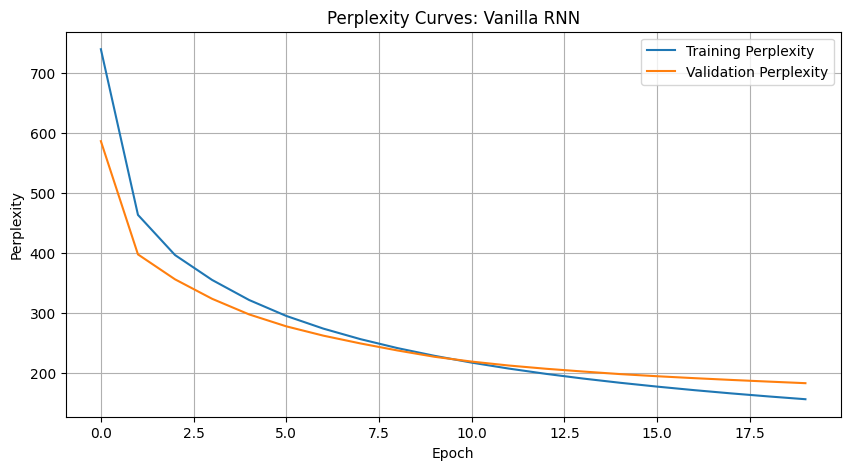

In [19]:
plot_loss_curves(train_perplexities, valid_perplexities, "Vanilla RNN")

In [20]:
import torch.nn as nn

def get_test_perplexity(model, test_loader):
    model.eval()
    total_loss = 0
    total_words = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            model.reset_h(batch_size)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets)
            total_loss += loss.item() * inputs.size(0) * inputs.size(1)
            total_words += inputs.size(0) * inputs.size(1)

    avg_loss = total_loss / total_words
    perplexity = math.exp(avg_loss)

    return perplexity

In [22]:
test_loader = create_loader(test_tokens, batch_size, seq_length)

In [23]:
test_perplexity = get_test_perplexity(rnn, test_loader)
print(f"Test perplexity on Vanilla RNN: {test_perplexity}")

Test perplexity on Vanilla RNN: 182.82330307059007


In [27]:
torch.save(rnn.state_dict(), "rnn_state_dict.pth")